# Chapter 4: Implementing a GPT Model from Scratch to Generate Text

In [1]:
from importlib.metadata import version

print("matplotlib version:", version("matplotlib"))
print("torch version:", version("torch"))
print("tiktoken version:", version("tiktoken"))

matplotlib version: 3.10.8
torch version: 2.9.1
tiktoken version: 0.12.0


## 4.1 Coding an LLM Architecture

*Generative Pre-trained Transformer (GPT)* models are large deep neural network architectures designed to generate human-like text one token at a time.

In this chapter, we will focus on building a smaller version of GPT-2 model from scratch using PyTorch.

In [1]:
# Configuration details for the 124M parameter GPT-2 model
GPT_CONFIG_124M = {
    "vocab_size": 50257,        # Vocabulary size (same as used by the BPE tokenizer)
    "context_length": 1024,     # Context length (maximum number of tokens in input via positional encoding)
    "emb_dim": 768,             # Embedding dimension
    "n_heads": 12,              # Number of attention heads (number of attention heads in multi-head attention)
    "n_layers": 12,             # Number of transformer layers (number of transformer blocks)
    "drop_rate": 0.1,           # Dropout rate (10% dropout)
    "qkv_bias": False,          # Whether to use bias in QKV projections
}

We will use the above configuration details to implement a GPT placeholder architecture.

In [2]:
import torch
import torch.nn as nn

In [3]:
class DummyTransformerBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        # A simple placeholder for a transformer block.

    def forward(self, x):
        # This block does nothing and just returns its input.
        return x
    

class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        # A simple placeholder for layer normalization.
        # The parameters are just to mimic the LayerNorm interface.

    def forward(self, x):
        # This layer norm does nothing and just returns its input.
        return x

In [4]:
class DummyGPTModel(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.tok_emb = nn.Embedding(
            num_embeddings=config['vocab_size'],
            embedding_dim=config['emb_dim']
        )
        self.pos_emb = nn.Embedding(
            num_embeddings=config['context_length'],
            embedding_dim=config['emb_dim']
        )
        self.drop_emb = nn.Dropout(p=config['drop_rate'])

        # Use a placeholder for `TransformerBlock` for now
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(config) for _ in range(config['n_layers'])]
        )

        # Use a placeholder for `LayerNorm` for now
        self.final_norm = DummyLayerNorm(normalized_shape=config['emb_dim'])

        # Output layer
        self.out_head = nn.Linear(
            in_features=config['emb_dim'],
            out_features=config['vocab_size'],
            bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))

        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)

        return logits

The `DummyGPTModel` class defines a simplified version of a GPT-like model. This is pretty straightforward and serves as a placeholder. The model architecture consists of:
- token and positional embeddings
- dropout layer
- a series of transformer blocks (not implemented here, just a placeholder `DummyTransformerBlock`)
- a final layer normalization (`DummyLayerNorm`)
- a linear output layer to project the hidden states back to the vocabulary size for token prediction

Any required parameters are passed through the `GPT_CONFIG_124M` dictionary.

Next we need to prepare the input data and initialize a new GPT model instance to test the architecture.

To start with, we will tokenize a batch of two text inputs for the GPT model:

In [7]:
import tiktoken

tokenizer = tiktoken.get_encoding('gpt2')

batch = []

txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)  # Shape: (batch_size, seq_len)
print("Input batch shape:", batch.shape)
print("Input batch:\n", batch)

Input batch shape: torch.Size([2, 4])
Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


Next, we can initialize the GPT model using the configuration dictionary and pass the tokenized inputs through the model to obtain the output logits.

In [8]:
torch.manual_seed(0)

model = DummyGPTModel(GPT_CONFIG_124M)

logits = model(batch)
print("Output logits shape:", logits.shape)
print("Output logits:\n", logits)

Output logits shape: torch.Size([2, 4, 50257])
Output logits:
 tensor([[[ 1.0542, -1.1131,  1.0358,  ...,  1.2142, -0.2719,  0.5218],
         [ 0.4354, -1.1167,  0.2321,  ..., -0.3016, -0.4041, -0.5582],
         [ 0.4960, -0.9935,  0.2223,  ..., -0.4815,  0.0151, -0.2848],
         [ 1.6846, -1.3228, -0.3068,  ...,  1.2541, -1.1059, -0.8833]],

        [[ 1.1409, -0.2005,  0.9094,  ...,  0.3253, -0.3749,  0.8058],
         [ 0.2844, -1.7189,  1.3266,  ..., -0.0942,  0.2244, -0.4697],
         [ 0.3551, -0.4782,  0.3904,  ..., -0.7720,  0.2114,  0.7489],
         [ 2.2828, -0.1362,  0.5286,  ...,  0.1818,  0.5542, -0.8470]]],
       grad_fn=<UnsafeViewBackward0>)


The output tensor has
- 2 rows corresponding to the 2 input sequences,
- 4 tokens (context length) per sequence, and
- 50,257-dimensional vectors representing the logits for each token in the vocabulary.

## 4.2 Normalizing Activations with Layer Normalization

**Layer Normalization** is a technique used to stabilize and accelerate the training of deep neural networks by normalizing the activations within a layer. The main idea is to adjust the activations so that they have a mean of zero and a standard deviation of one, which helps to mitigate issues like internal covariate shift.

In GPT-2 and modern transformer architectures, layer normalization is typically applied before or after the multi-head attentions and before the final output layer.

To begin with, we will first see how to implement layer normalization from scratch and how it works with tensors. Asssume we have a linear layer with 5 input features and 6 output features as well as two samples in a batch.

In [9]:
torch.manual_seed(0)

# Create a batch of 2 samples with 5 input features each
batch_example = torch.randn(2, 5)
print("Example batch shape:", batch_example.shape)
print("Example batch:\n", batch_example)

Example batch shape: torch.Size([2, 5])
Example batch:
 tensor([[ 1.5410, -0.2934, -2.1788,  0.5684, -1.0845],
        [-1.3986,  0.4033,  0.8380, -0.7193, -0.4033]])


In [10]:
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print("Output after linear layer and ReLU shape:", out.shape)
print("Output after linear layer and ReLU:\n", out)

Output after linear layer and ReLU shape: torch.Size([2, 6])
Output after linear layer and ReLU:
 tensor([[0.8963, 1.2654, 0.6489, 0.0000, 0.3516, 0.0000],
        [0.0000, 0.4422, 0.6083, 0.6321, 0.6686, 0.5418]],
       grad_fn=<ReluBackward0>)


Before we apply layer normalization, let's check the mean and variance of the output tensor:

In [11]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)

print("Mean of output (per sample):\n", mean)
print("Variance of output (per sample):\n", var)

Mean of output (per sample):
 tensor([[0.5270],
        [0.4822]], grad_fn=<MeanBackward1>)
Variance of output (per sample):
 tensor([[0.2565],
        [0.0622]], grad_fn=<VarBackward0>)


The normalization is performed across the feature dimension (last dimension) for each sample in the batch. This means that for each sample, we compute the mean and variance of its features, and then normalize those features accordingly.

Even later when we add layer normalization to our GPT model, which produces 3-dimensional tensors with shape `[batch_size, num_tokens, embedding_size]`, we can still use `dim=-1` for normalization across the last dimension (feature dimension) for each token in each sample.

Next we can apply layer normalization to the output tensor. We will subtract the mean and divide by the standard deviation for each sample in the batch.

In [12]:
out_norm = (out - mean) / torch.sqrt(var)
print("Output after layer normalization shape:", out_norm.shape)
print("Output after layer normalization:\n", out_norm)

mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("Mean after layer normalization (per sample):\n", mean)
print("Variance after layer normalization (per sample):\n", var)

Output after layer normalization shape: torch.Size([2, 6])
Output after layer normalization:
 tensor([[ 0.7291,  1.4578,  0.2406, -1.0406, -0.3463, -1.0406],
        [-1.9340, -0.1602,  0.5060,  0.6014,  0.7476,  0.2393]],
       grad_fn=<DivBackward0>)
Mean after layer normalization (per sample):
 tensor([[-3.9736e-08],
        [ 1.1921e-07]], grad_fn=<MeanBackward1>)
Variance after layer normalization (per sample):
 tensor([[1.],
        [1.]], grad_fn=<VarBackward0>)


The output after layer normalization now contains features that have a mean close to 0 and variance close to 1 for each sample in the batch, demonstrating the effect of layer normalization.

In [13]:
# Better readability
torch.set_printoptions(sci_mode=False)
print("Mean after layer normalization (per sample):\n", mean)
print("Variance after layer normalization (per sample):\n", var)

Mean after layer normalization (per sample):
 tensor([[-0.0000],
        [ 0.0000]], grad_fn=<MeanBackward1>)
Variance after layer normalization (per sample):
 tensor([[1.],
        [1.]], grad_fn=<VarBackward0>)


Applying the same idea, we now can implement a `LayerNorm` class:

In [14]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()

        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)

        norm_x = (x - mean) / torch.sqrt(var + self.eps)

        return self.scale * norm_x + self.shift

The `eps` variable is used to prevent division by zero in case the variance is extremely small.

The `scale` and `shift` parameters are trainable parameters (of the same dimension as the input) that the LLM automatically adjusts during training if it is determined that doing so would improve the model's performance on its training task, allowing the model to learn appropriate scaling and shifting that best suit the data it is processing.

In the variance calculation, we use `unbiased=False` to compute the population variance ($\frac{\sum_i(x_i - \mu)^2}{n}$) instead of the sample variance ($\frac{\sum_i(x_i - \mu)^2}{n-1}$) where $n$ is the sample size (here, the number of features). This decision results in a *biased estimate* of the variance. For LLMs, where the embedding size (number of features) is typically large, the difference between the biased and unbiased estimates becomes negligible. 

We go with the biased estimate which is what GPT-2 uses as well for computational efficiency and simplicity so that our method is compatible with the pretrained weights later on.

In [15]:
# Test the LayerNorm class
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)

In [16]:
mean_example = batch_example.mean(dim=-1, keepdim=True)
var_example = batch_example.var(dim=-1, keepdim=True, unbiased=False)
print("Mean of example batch (per sample):\n", mean_example)
print("Variance of example batch (per sample):\n", var_example)

mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, keepdim=True, unbiased=False)
print("Mean after LayerNorm (per sample):\n", mean)
print("Variance after LayerNorm (per sample):\n", var)

Mean of example batch (per sample):
 tensor([[-0.2895],
        [-0.2560]])
Variance of example batch (per sample):
 tensor([[1.6577],
        [0.6347]])
Mean after LayerNorm (per sample):
 tensor([[0.0000],
        [0.0000]], grad_fn=<MeanBackward1>)
Variance after LayerNorm (per sample):
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


*Batch normalization* normalizes across the batch dimension, while *layer normalization* normalizes across the feature dimension for each individual sample.

LLMs often require significant computational resources, and the available hardware or the specific use case can dictate the batch size during training or inference. Since layer normalization normalizes each sample independently of the batch size, it is more flexible and can handle varying batch sizes without affecting the normalization process. This is beneficial for distributed training or when deploying models in environments where resources are limited.

## 4.3 Implementing a Feed-Forward Network with GELU Activations

Besides the traditional ReLU activation function, LLMs often use the *Gaussian Error Linear Unit (GELU)* activation function and *Swish-gated Linear Unit (SwiGLU)* activation function in their feed-forward networks (FFNs) for better performance.

For GELU, the exact formula is:
$$
\text{GELU}(x) = x \cdot \Phi(x)
$$
where $\Phi(x)$ is the cumulative distribution function of the standard Gaussian distribution. In practice, an efficient approximation is often used:
$$
\text{GELU}(x) \approx 0.5 \cdot x \left(1 + \tanh\left(\sqrt{\frac{2}{\pi}} \left(x + 0.044715x^3\right)\right)\right)
$$

In [17]:
# Python implementation of GELU activation function
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

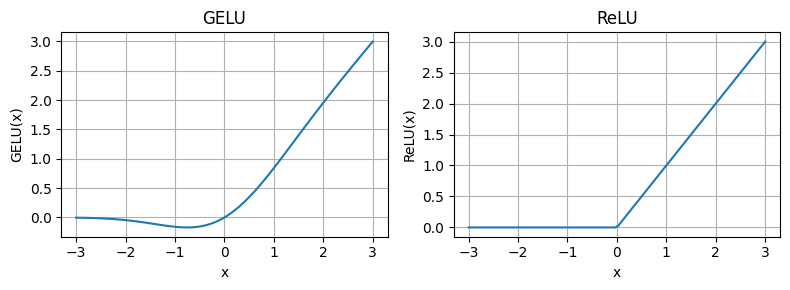

In [18]:
# Visual comparison of ReLU and GELU
import matplotlib.pyplot as plt

gelu = GELU()
relu = nn.ReLU()

# sample data
x = torch.linspace(-3, 3, 100)
y_gelu = gelu(x)
y_relu = relu(x)

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ['GELU', 'ReLU'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(x, y)
    plt.title(label)
    plt.xlabel('x')
    plt.ylabel(f"{label}(x)")
    plt.grid()
plt.tight_layout()
plt.show()

Compared to ReLU, GELU provides a smoother transition for negative inputs, which can help with gradient flow during training and lead to better performance in deep networks.

Next, we will use the GELU function to implement a small feed-forward network (FFN) module commonly used in transformer architectures.

In [19]:
class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(config['emb_dim'], 4 * config['emb_dim']),
            GELU(),
            nn.Linear(4 * config['emb_dim'], config['emb_dim']),
        )

    def forward(self, x):
        return self.layers(x)

In [20]:
print("Embedding dimension:", GPT_CONFIG_124M['emb_dim'])

ffn = FeedForward(GPT_CONFIG_124M)

# input shape: [batch_size, num_token, emb_dim]
x = torch.rand(2, 3, 768)

out = ffn(x)
print("Output shape from FeedForward network:", out.shape)

Embedding dimension: 768
Output shape from FeedForward network: torch.Size([2, 3, 768])


The `FeedForward` class enhances the model's ability to learn from and generalize the data. This expansion is followed by a nonlinear GELU activation and then a contraction back to the original embedding size for exploiting complex patterns in the data.

## 4.4 Adding Shortcut Connections

A shortcut connection creates an alternative shorter path for the gradient to flow through the network during backpropagation. This helps to mitigate the vanishing gradient problem, allowing gradients to reach earlier layers more effectively.

In [21]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()

        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU()),
        ])

    def forward(self, x):
        for layer in self.layers:
            # Compute the output of the current layer
            layer_output = layer(x)
            # Check if shortcut can be applied
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output  # Apply shortcut connection
            else:
                x = layer_output  # No shortcut, just use the layer output

        return x

In [22]:
def print_gradients(model, x):
    # Forward pass
    output = model(x)
    target = torch.tensor([[0.]])

    # Calculate loss based on how close the target is to the output
    loss = nn.MSELoss()
    loss_val = loss(output, target)

    # Backward pass
    loss_val.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            # Print the mean absolute gradient of the weights
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

Let's try a neural network without shortcut connections.

In [24]:
torch.manual_seed(0)

layer_sizes = [3, 3, 3, 3, 3 ,1]
sample_input = torch.tensor([[1., 0., -1.]])

model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes=layer_sizes,
    use_shortcut=False
)

print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.0021742500830441713
layers.1.0.weight has gradient mean of 0.0018201650818809867
layers.2.0.weight has gradient mean of 0.0023985703010112047
layers.3.0.weight has gradient mean of 0.01912502758204937
layers.4.0.weight has gradient mean of 0.26376065611839294


As we can see, without shortcut connections, the gradients become smaller as we progress from the last layer (`layer.4`) to the first layer (`layer.0`). This indicates that the gradients are vanishing, which can hinder effective learning in deeper networks.

Now let's add shortcut connections to the network.

In [25]:
torch.manual_seed(0)

model_with_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes=layer_sizes,
    use_shortcut=True
)

print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.010206019505858421
layers.1.0.weight has gradient mean of 0.009498980827629566
layers.2.0.weight has gradient mean of 0.0024669563863426447
layers.3.0.weight has gradient mean of 0.025129124522209167
layers.4.0.weight has gradient mean of 0.09313038736581802


The last layer (`layer.4`) still has a relatively large gradient, but the earlier layers now have significantly larger gradients compared to the network without shortcut connections. This demonstrates that shortcut connections help preserve gradient magnitude across layers, facilitating better learning in deep networks.

## 4.5 Connecting Attention and Linear Layers in a Transformer Block

We now have all the necessary components to build a complete transformer block by connecting the multi-head attention layer and the feed-forward network with layer normalization and shortcut connections, and this fundamental buliding block can be stacked multiple times to create a deep transformer architecture like GPT.

In [28]:
# Import MultiHeadAttention class we defined in Chapter 3
from llms_from_scratch.ch03 import MultiHeadAttention

In [29]:
class TransformerBlock(nn.Module):
    def __init__(self, config):
        super().__init__()

        # Same as before
        self.att = MultiHeadAttention(
            d_in=config['emb_dim'],
            d_out=config['emb_dim'],
            context_length=config['context_length'],
            num_heads=config['n_heads'],
            dropout=config['drop_rate'],
            qkv_bias=config['qkv_bias']
        )

        # Feed-forward network
        self.ff = FeedForward(config)
        # Layer normalization layers
        self.ln1 = LayerNorm(config['emb_dim'])
        self.ln2 = LayerNorm(config['emb_dim'])
        # Dropout layer
        self.dropout = nn.Dropout(p=config['drop_rate'])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.ln1(x)
        x = self.att(x) # Shape: [batch_size, seq_len, emb_dim]
        x = self.dropout(x)
        x = x + shortcut # Apply shortcut connection

        # Shortcut connection for feed-forward network
        shortcut = x
        x = self.ln2(x)
        x = self.ff(x)  # Shape: [batch_size, seq_len, emb_dim]
        x = self.dropout(x)
        x = x + shortcut # Apply shortcut connection

        return x

Layer normalization is applied before each of the multi-head attention and feed-forward network sub-layers, and dropout is used after each sub-layer to prevent overfitting. This is known as *Pre-LayerNorm*.

Older transformer architectures used *Post-LayerNorm*, where layer normalization is applied after the self-attention and feed-forward sub-layers. However, Pre-LayerNorm has been found to be more stable during training, especially for deeper networks.

In [30]:
# Test the TransformerBlock
torch.manual_seed(0)
x = torch.rand(2, 4, 768)  # Example input: batch_size=2, num_token=4, emb_dim=768
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


As we can see, the transformer block maintains the input shape in its output, indicating that the transformer architecture processes sequences of data without altering their shape throughout the network. This property is crucial for tasks involving sequential data, such as natural language processing, where the sequence length must be preserved.

## 4.6 Coding the GPT Model

Now we can replace the `DummyTransformerBlock` and `DummyLayerNorm` in our GPT model with the actual `TransformerBlock` and `LayerNorm` implementations to create a functional GPT architecture.

Note that the transformer block is repeated multiple times; in the case of the smallest GPT-2 model, it is repeated 12 times to form a deep network capable of learning complex patterns in text data. This corresponding to the `n_layers` parameter in the `GPT_CONFIG_124M` dictionary.

In [32]:
print("Configuration for GPT-2 124M model:\n", GPT_CONFIG_124M)

Configuration for GPT-2 124M model:
 {'vocab_size': 50257, 'context_length': 1024, 'emb_dim': 768, 'n_heads': 12, 'n_layers': 12, 'drop_rate': 0.1, 'qkv_bias': False}


In [33]:
class GPTModel(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.tok_emb = nn.Embedding(
            num_embeddings=config['vocab_size'],
            embedding_dim=config['emb_dim']
        )
        self.pos_emb = nn.Embedding(
            num_embeddings=config['context_length'],
            embedding_dim=config['emb_dim']
        )
        self.drop_emb = nn.Dropout(p=config['drop_rate'])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(config) for _ in range(config['n_layers'])]
        )

        self.final_norm = LayerNorm(emb_dim=config['emb_dim'])

        self.out_head = nn.Linear(
            in_features=config['emb_dim'],
            out_features=config['vocab_size'],
            bias=False
        )

    def forward(self, in_idx):
        # index shape: [batch_size, seq_len] or [batch_size, num_tokens]
        batch_size, seq_len = in_idx.shape

        # Token and positional embeddings
        tok_embeds = self.tok_emb(in_idx)  # Shape: [batch_size, seq_len, emb_dim]
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))  # Shape: [seq_len, emb_dim]
        x = tok_embeds + pos_embeds  # Shape: [batch_size, seq_len, emb_dim]

        x = self.drop_emb(x)
        x = self.trf_blocks(x)  # Shape: [batch_size, seq_len, emb_dim]
        x = self.final_norm(x)  # Shape: [batch_size, seq_len, emb_dim]
        logits = self.out_head(x)  # Shape: [batch_size, seq_len, vocab_size]
        return logits

Remind that the embedding layers (`tok_emb` and `pos_emb`) are responsible for converting input token indices into dense vector representations and adding positional information to these embeddings, respectively. These layers are crucial for the model to understand the context and order of tokens in the input sequence, as we discussed in Chapter 2.

Now we can initialize a 124M GPT-2 model with the `GPT_CONFIG_124M` configuration dictionary we defined earlier.

In [34]:
torch.manual_seed(0)

model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print("Input batch shape:", batch.shape)
print("Input batch:\n", batch)
print("\nOutput logits shape:", out.shape)
print("Output logits:\n", out)

Input batch shape: torch.Size([2, 4])
Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output logits shape: torch.Size([2, 4, 50257])
Output logits:
 tensor([[[-1.1000,  0.5460,  0.5332,  ...,  0.4144, -0.1159,  0.1868],
         [-0.1678, -0.1384,  0.0151,  ...,  0.4356, -0.0620,  0.3977],
         [-0.1707,  0.0207, -0.1978,  ..., -0.0503,  0.3358, -0.4299],
         [-0.1184, -0.4138,  0.2432,  ...,  1.2942,  0.1587, -0.8207]],

        [[-0.5338,  0.2238,  0.5445,  ...,  0.0741, -0.7147,  0.0675],
         [-0.1699, -0.0242, -0.5727,  ...,  0.4784, -0.4581,  0.6214],
         [-0.6074, -0.0871, -0.3612,  ..., -0.2842,  0.1463,  0.6657],
         [-0.2279, -0.1704,  0.6844,  ..., -0.3375, -0.0054, -0.3893]]],
       grad_fn=<UnsafeViewBackward0>)


Using the `numel()` method (short for "number of elements"), we can check the total number of parameters in the GPT model.

In [36]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters in GPT model: {total_params:,}")

Total number of parameters in GPT model: 163,009,536


Instead of 124M parameters, we get 163M parameters. This discrepancy arises because of the concept of *tying weights* which was used in the original GPT-2 implementation. Weight tying means that the original GPT-2 architecture reuses the weights from the token embedding layer in its output layer, by setting `self.out_head.weight = self.tok_emb.weight` in the model's initialization. This effectively reduces the total number of unique parameters in the model, as the same weights are used for both embedding and output projection.

To understand this better, let's check those weights.

In [38]:
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output head layer shape:    ", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output head layer shape:     torch.Size([50257, 768])


- The token embedding layer projects the 50,257-dimensional one-hot encoded input tokens into 768-dimensional dense embedding representations.
- The output head layer projects the 768-dimensional hidden states back to the 50,257-dimensional vocabulary space for token prediction so that we can convert these back into words.

This is why the embedding and output layers have the same number of weight parameters.

If we apply weight tying in our GPT model by setting `model.out_head.weight = model.tok_emb.weight` after initializing the model, we can subtract the number of parameters in the output head from the total parameter count to get the correct number of unique parameters in the model.

In [39]:
total_params_gpt2 = total_params - sum(p.numel() for p in model.out_head.parameters())
print(f"Total number of unique parameters in GPT-2 model with weight tying: {total_params_gpt2:,}")

Total number of unique parameters in GPT-2 model with weight tying: 124,412,160


Weight tying reduces the overall memory footprint and computational complexity of the model.

Finally, we can also compute the memory requirements of our 163M-parameter GPT model:

In [40]:
# Calculate the total size in bytes (assuming float32, 4 bytes per parameter)
total_size_bytes = total_params * 4

# Convert to megabytes
total_size_mb = total_size_bytes / (1024 ** 2)
print(f"Total memory required for GPT model parameters: {total_size_mb:.2f} MB")

Total memory required for GPT model parameters: 621.83 MB


Therefore, assuming each parameter is stored as a 32-bit floating-point number (4 bytes), our GPT model would require approximately 651.83 MB of memory to store all its parameters.

## 4.7 Generating Text

The GPT model generates text given an input context. With each iteration, the input context grows allowing the model to generate coherent and contextually relevant text.

In the following `generate_text_simple` function, we will implement greedy decoding to generate text from the GPT model.

In [41]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, num_tokens) array of indices in the current context
    for _ in range(max_new_tokens):
        # Crop current context if it exceeds the supported context size
        # e.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]

        # Get the predictions:
        with torch.no_grad():
            logits = model(idx_cond)

        # Focus only on the last time step
        # logits shape: (batch_size, num_tokens, vocab_size) becomes (batch_size, vocab_size)
        logits = logits[:, -1, :]

        # Apply softmax to get probabilities
        probs = torch.softmax(logits, dim=-1) # Shape: (batch_size, vocab_size)

        # Get the idx of the vocab dimension with the highest probability (greedy decoding)
        idx_next = torch.argmax(probs, dim=-1, keepdim=True)  # Shape: (batch_size, 1)

        # Append the sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # Shape: (batch_size, num_tokens + 1)

    return idx

In practice, the softmax step is redundant since the position with the highest score in the softmax output tensor is the same position in the logit tensor.

The *greedy decoding* strategy selects the token with the highest probability at each step, but it may not always produce the most diverse or contextually rich text. More advanced techniques like beam search or sampling methods can be used to improve the quality of generated text.

In [42]:
# Test
start_context = "Hello, I am"

encoded = tokenizer.encode(start_context)
print("Encoded start context:", encoded)

encoded_tensor = torch.tensor(encoded).unsqueeze(0)  # Shape: (1, num_tokens) # Add batch dimension
print("Encoded tensor shape:", encoded_tensor.shape)

Encoded start context: [15496, 11, 314, 716]
Encoded tensor shape: torch.Size([1, 4])


In [43]:
model.eval() # Set the model to evaluation mode to disable dropout

out = generate_text_simple(
    model=model,
    idx=encoded_tensor,
    max_new_tokens=6,
    context_size=GPT_CONFIG_124M['context_length']
)
print("Generated token indices:", out)
print("Generated output length:", len(out[0]))

Generated token indices: tensor([[15496,    11,   314,   716, 42134, 43541, 42296, 37511, 45799,  7309]])
Generated output length: 10


In [44]:
# Remove batch dimension and decode the generated tokens
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print("Generated text:", decoded_text)

Generated text: Hello, I am PracticesAmidFUNLastly sprinkle plastic
